In [13]:
import sys
sys.path.append('/home/v-runmao/projects/DomShift-ATMF/')

from importlib import reload

import precompute_vis
reload(precompute_vis)

from analysis import helper
reload(helper)

from analysis.helper import do_for_all_algo_and_tgt, cmp_binary_pred_and_label, get_pred_and_prob
from analysis.helper import get_model_from_root, load_bert_classifier, display_metrics_nicely
from precompute_vis import load_and_visualize, visualize, visualize_adversary

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Codes that only need running once

In [2]:
def check_negation(x):
    """Check whether a piece of text has negation words in it
    """
    # define the negation words here
    single = ['no', 'not', 'none', 'nothing', 'nobody', 'nowhere', 'never', 'neither']
    composite = ["don't", "doesn't", "didn't",
                 "aren't", "isn't", "wasn't",
                 "haven't", "hasn't", "hadn't",
                 "cannot", "can't", "couldn't",
                 "shouldn't", "wouldn't", "won't"]
    adverbs = ['barely', 'hardly', 'scarcely']
    all_neg = single + composite + adverbs
    
    # get all the tokens of the input
    tokens = [t.lower() for t in x.strip().split()]
    return any([n in tokens for n in all_neg])


def append_information():
    """Append `has_negation' and `num_token', 'ERM_pred' to the original DataFrame dataset.
    """
    raw_path = '/home/v-runmao/projects/DomShift-ATMF/data/data_root/preprocessed.csv'
    save_path = '/home/v-runmao/projects/DomShift-ATMF/analysis/IRM/postprocessed.csv'
    raw_data = pd.read_csv(raw_path).iloc[:, 1:]

    # flag of has_negation, and number of tokens
    has_negation = []
    num_token = []

    # loop through all the texts
    for ix in raw_data.index:
        text = raw_data.loc[ix, 'text']
        has_negation.append(check_negation(text))
        num_token.append(len(text.strip().split()))
    print(f'Total: {len(raw_data)}\nHas negation: {sum(has_negation)}')

    # append has_negation and num_token
    raw_data['has_negation'] = has_negation
    raw_data['num_token'] = num_token
    
    # append ERM predictions and prediction confidence
    raw_data['ERM_pred'] = 0
    raw_data['ERM_pred_prob'] = -1
    for target in 'ATMF':
        model = get_model_from_root('../../pt/all_best/ERM_BEST', f'ERM_tgt_{target}').to('cuda:0')
        model.eval()
        pred, pred_prob = get_pred_and_prob(model, raw_data.loc[raw_data['domain']==target, 'text'].tolist())
        raw_data.loc[raw_data['domain']==target, 'ERM_pred'] = pred
        raw_data.loc[raw_data['domain']==target, 'ERM_pred_prob'] = pred_prob

    raw_data.to_csv(save_path, index=False)
    
    
def single_src_model_acc(source: str) -> dict:
    """Load the model finetuned on `source' domain and get the acc, precision, etc., on all
    other domains. Return a dict containing two items for each target: one w.r.t. the full
    target domain, the other w.r.t. the negation subset of the target domain. The value of
    either item is also a dict, from str to float.
    """
    # load model
    model_path = f'/home/v-runmao/projects/DomShift-ATMF/pt/all_default/ORACLE_default/ORACLE_tgt_{source}/best_model.pth'
    model = load_bert_classifier(model_path).to('cuda:0')
    model.eval()
    assert model.device == 'cuda:0' 
    
    # read all data
    data = pd.read_csv('postprocessed.csv')
    l2i = {'positive': 1, 'negative': 0}
    
    # the results are saved in dict
    res = {}
    
    # inference for every other domain
    for target in 'ATMF':
        if target == source:
            continue
        dom = data[data['domain'] == target].copy()
        pred, _ = get_pred_and_prob(model, dom['text'].tolist())
        dom['pred'] = pred
        dom.replace(to_replace={'pred': l2i, 'label': l2i}, inplace=True)
        
        # accuracy on full target domain
        print('{:^64s}'.format(f'source: {source}   |   target: {target}'))
        r1 = cmp_binary_pred_and_label(dom['pred'], dom['label'])
        
        # accuracy on negation subset
        neg_subset = dom[dom['has_negation']]
        r2 = cmp_binary_pred_and_label(neg_subset['pred'], neg_subset['label'], header=False)
        
        res[(source, target, 'all')] = r1
        res[(source, target, 'negation')] = r2
    
    return res


def multi_src_model_acc(target: str) -> dict:
    """Load the ERM model targeted `target' and get the acc, precision, etc. Same as
    `single_src_model_acc', this function does this for the full target data and the
    negation subset.
    """
    # load model
    model = get_model_from_root('../../pt/all_best/ERM_BEST', f'ERM_tgt_{target}').to('cuda:0')
    model.eval()
    
    # get data
    data = pd.read_csv('postprocessed.csv')
    data = data[data['domain'] == target].copy()
    l2i = {'positive': 1, 'negative': 0}
    
    # get predictions
    pred, _ = get_pred_and_prob(model, data['text'].tolist())
    data['pred'] = pred
    data.replace(to_replace={'pred': l2i, 'label': l2i}, inplace=True)
    
    # accuracy on full target domain
    print('{:^64s}'.format(f'target: {target}'))
    r1 = cmp_binary_pred_and_label(data['pred'], data['label'])

    # accuracy on negation subset
    neg_subset = data[data['has_negation']]
    r2 = cmp_binary_pred_and_label(neg_subset['pred'], neg_subset['label'], header=False)
    
    return {(target, 'all'): r1, (target, 'negation'): r2}


#### under no circumstances need you uncomment this ####
# append_information()                                 #
########################################################

# Analysis
### Helper functions

In [3]:
def quarter_pie():
    """Draw a pie chart that contains four pies, i.e., {no_negation, has_negation} cross {y=1, y=0},
    for each domain and all the domains combined.
    """
    all_data = pd.read_csv('postprocessed.csv')
    fig, axes = plt.subplots(2, 3, figsize=(16, 12))
    
    for i, d in enumerate(['A', 'T', 'ALL', 'M', 'F']):
        ax = axes[i//3][i%3]
        data = all_data[all_data['domain'] == d] if d != 'ALL' else all_data
        
        types = ['no negation & y = 1', 'no negation & y = 0', 'has negation & y = 0', 'has negation & y = 1']
        cnts = [len(data[(~data['has_negation']) & (data['label'] == 'positive')]),
                len(data[(~data['has_negation']) & (data['label'] == 'negative')]),
                len(data[(data['has_negation']) & (data['label'] == 'negative')]),
                len(data[(data['has_negation']) & (data['label'] == 'positive')])]
        explode = [0, 0, 0, 0]
        assert sum(cnts) == len(data)
        
        # create pie chart
        wedges = ax.pie(cnts, startangle=90, explode=explode)[0]
        ax.legend(wedges, [f'{t} ({100*c/sum(cnts):.1f}%)' for t, c in zip(types, cnts)], loc='lower left')
        ax.axis('equal')  # draw a circle
        ax.set_title(f'Domain: {d}, Size: {len(data)}', weight='bold')
        
    fig.delaxes(axes[1][2])  # remove extra axes
    fig.show()


def single_src_bar():
    with open('./oracle_res.pkl', 'rb') as fi:
        res = pickle.load(fi)
    keys = list(next(iter(res[0].values())).keys())  # keys are acc, precision, etc.
    assert len(keys) == 6
    
    width = 0.135
    domains = ['A', 'T', 'M', 'F']
    colors = ['C0', 'C1', 'C2', 'C3']
    d2i = {d: i for i, d in enumerate(domains)}
    fig, axes = plt.subplots(5, 1, figsize=(16, 12))
    
    for i, k in enumerate(keys[1:]):
        ax = axes[i]
        for src in domains:
            targets = [t for t in domains if t != src]
            # offset \in {-1, 0, 1}
            offsets = np.array([d2i[src] if d2i[src] < d2i[t] else d2i[src] - 1 for t in targets]) - 1
            # coordinate \in {0, 1, 2, 3}
            coors = np.array([d2i[t] for t in targets])
            # the bars to plot
            values_all = np.array([res[d2i[src]][(src, t, 'all')][k] for t in targets]) * 100
            values_neg = np.array([res[d2i[src]][(src, t, 'negation')][k] for t in targets]) * 100
            
            rect1 = ax.bar(coors + offsets*width*2 - width/2, values_all, width=width, label=f'Train on {src}, Test on FULL', color=colors[d2i[src]], edgecolor='black')
            rect2 = ax.bar(coors + offsets*width*2 + width/2, values_neg, width=width, label=f'Train on {src}, Test on NEGATION', color=colors[d2i[src]], edgecolor='black', hatch='/')
            
            # only available after matplotlib 3.4.0
            ax.bar_label(rect1, padding=3, fmt='%.2f')
            ax.bar_label(rect2, padding=3, fmt='%.2f')
            
        ax.set_ylabel(k)
        ax.set_ylim(top=115)
        ax.set_title(f'{k} by Train and Test Domain')
        ax.set_xticks(range(len(domains)))
        ax.set_xticklabels(domains)
        handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, fontsize='large', loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=4)
    fig.tight_layout()
    fig.show()


@do_for_all_algo_and_tgt(['ERM'], 'ATMF')
def multi_src_tab(algorithm=None, target=None):
    """Dispaly acc, precision and recall, etc., on the full `target' domain
    as well as the negation subset, using `algorithm', in a tabular fashion.
    After being decorated, this function runs for all target domains.
    """
    fname = f'{algorithm.lower()}_res.pkl'
    with open(fname, 'rb') as fi:
        res = pickle.load(fi)
    res_all = [x[(target, 'all')] for x in res if (target, 'all') in x]
    res_neg = [x[(target, 'negation')] for x in res if (target, 'negation') in x]
    assert len(res_all) == 1 and len(res_neg) == 1
    
    print('{:^64s}'.format(f'algo: {algorithm}   |   target: {target}'))
    display_metrics_nicely(res_all[0], header=True)
    display_metrics_nicely(res_neg[0], header=False)
    
    print('\n')

## Data Properties
See the pie charts below.

### Conclusions
<!---1. In all domains but MSN, a sample that has negation words is more likely to express negative sentiment than positive sentiment. In other words, $P(y=0|\textrm{has negation}) > P(y=1|\textrm{has negation})$.
    - Particularly, in Twitter domain, if I predict $y=0$ whenever I see a negation word, I have $94\%$ chance to be correct. In contrast, always predicting $y=0$ gets $79\%$ accuracy in this domain.

2. In all domains but Twitter, a sample without negation words is more likely to express positive sentiment than negative sentiment. In other words, $P(y=1|\textrm{no negation}) > P(y=0|\textrm{no negation})$.
    - Particularly, in Amazon domain, if I predict $y=1$ whenever I don't see any negation, I have $69.4\%$ chance to be correct.
-->

1. The coverage of negations varies among domains. In Amazon and Twitter, a large portion of texts contain negations. When mixed, the proportion is still high.
    | Amazon | Twitter |   MSN  | Finance | Overall |
    | :----: | :-----: | :---:  | :-----: | :-----: |
    | 0.732  | 0.281   | 0.087  | 0.009   | 0.380   |

1. When speaking of the posterior $P(y=0|\textrm{has negation})$, we must first rule out the effect of label imbalance. The table below shows that on all domains we have $P(y=0|\textrm{has negation})>P(y=0)$. Therefore, the existence of negations tells additional information about $y=0$.

    |                                | Amazon | Twitter |  MSN  | Finance | Overall |
    | :---                           | :----: | :-----: | :---: | :-----: | :-----: |
    | $P(y=0|\textrm{has negation})$ | 0.571  |  0.943  | 0.367 |  0.667  |  0.666  |
    | $P(y=0)$                       | 0.5    |  0.792  | 0.263 |  0.307  |  0.55   |
    
2. In contrast, $P(y=1|\textrm{no negation})$ is very close to $P(y=1)$ on most domains. Therefore, the nonexistence of negations doesn't necessarily bring more confidence in $y=1$.

    |                               | Amazon | Twitter |  MSN  | Finance | Overall |
    | :---                          | :----: | :-----: | :---: | :-----: | :-----: |
    | $P(y=1|\textrm{no negation})$ | 0.694  |  0.267  | 0.747 |  0.696  |  0.521  |
    | $P(y=1)$                      | 0.5    |  0.208  | 0.737 |  0.693  |  0.45   |

4. Consider the following classifiers that take naive heuristics. It's easy to get high accuracy by cheating.
    - C0: Always predict the majority label.
    - C1: Predict $y=0$ if the text has negation words and $y=1$ otherwise.
    - C2: Predict $y=0$ if the text has negation words; predict the majority otherwise.

    |        | Amazon | Twitter |  MSN  | Finance | Overall |
    | :---   | :----: | :-----: | :---: | :-----: | :-----: |
    | **C0** |  50%   |  79.2%  | 73.7% |  69.3%  |   55%   |
    | **C1** | 60.4%  |  45.7%  | 71.4% |  69.6%  |  57.6%  |
    | **C2** | 60.4%  |  79.2%  | 71.4% |  69.6%  |   55%   |

5. The Matthews correlation coefficient (or $\phi$ coefficient) between $y$ and $has\_negation$ is high (0 for no relation, +1 for perfect agreement).

    | Amazon | Twitter |   MSN  | Finance | Overall |
    | :----: | :-----: | :---:  | :-----: | :-----: |
    | 0.2348 | 0.2327  | 0.0735 | 0.0743  | 0.1822  |

6. The correlation between $y$ and negation words, though strong, varies among domains.

7. When mixed, the correlation is averaged, but still strong.

**In summary**, this tells us that negation is a good indicator of label, though to different extent among domains. This *doesn't* tell us whether a model like BERT would rely on this indicator excessively.

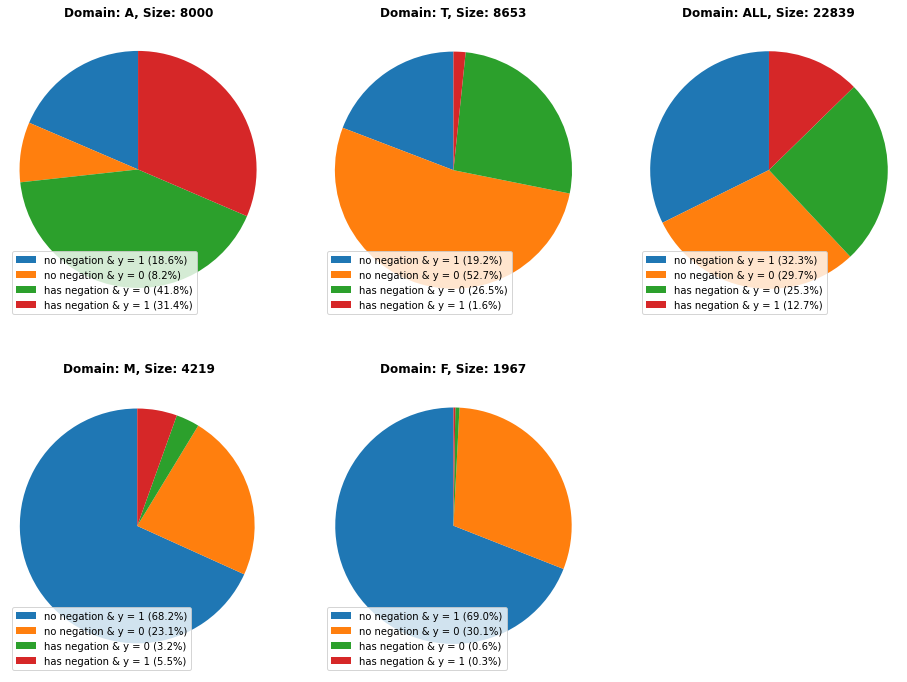

In [4]:
# draw pie charts
quarter_pie()

## Single-source-domain Models
### Hint
The accuracy, precision, etc., of all single-source-domain models have been saved in `oracle_res.pkl`. The format is list of dict of tuple $\to$ dict of str $\to$ float:


    [{(src1, tgt1, 'all'):
        {'acc': ..., 'precision': ...,},
      (src1, tgt1, 'negation'):
        {'acc': ..., 'precision': ...,},
      (src1, tgt2, 'all'):
        {'acc': ..., 'precision': ...,},
      ...
     },
     ...
    ]
    
$$\textrm{Precision}=\frac{TP}{TP+FP}, \textrm{Recall}=\frac{TP}{TP+FN}, \textrm{Specificity}=\frac{TN}{TN+FP}$$

The saved results are plotted in the bar charts below.

### Conclusions
1. In almost all cases, models have **lower recall and higher specificity** on the *negation subset* (the subset of samples that contain negations, marked with slash) than on the *full set*, regardless of the domain they are trained or tested on.
    - This is because models are biased towards predicting $y=0$ when there are negations (see previous section). Thus, TN and FN increases, and FP and TP decreases.
    
2. There is also a deterioration in precision when tested on the negation subset. Since FP and TP simultaneously decreases, this indicates the latter drops more sharply.
    
2. The model trained on <span style="color:#1f77b4"> Amazon domain </span> alone is surprisingly good. This may be because texts in this domain are very long and can cover more combinations of tokens.

3. The model trained on <span style="color:#ff7f0e"> Twitter domain </span> has very low accuracy although the size of this domain is the largest. This may be because the label distribution is severely imbalanced (<span style="color:#ff7f0e"> $79.2\%$ </span> negative labels). The very high precision and low recall demonstrate this.

4. The model trained on <span style="color:#2ca02c"> MSN domain </span> performs well when tested on <span style="color:#d62728"> Finance domain </span>, and vice versa. This may be because these two domains have similar label distributions (<span style="color:#2ca02c"> $73.7\%$ </span> and <span style="color:#d62728"> $69.3\%$ </span> positive labels, respectively). This again demonstrates the impact of label distribution on transferability.
    - Note that this is NOT because the texts of these two domains are similar. The average pairwise cosine similarity, based on tf-idf, between each two domains is displayed in the table below. We can see that the similarity between M and F is not high.
        |      |   A   |   T   |   M   |   F   |
        | :--- | :---: | :---: | :---: | :---: |
        |**A** | 0.094 | 0.034 | 0.036 | 0.031 |
        |**T** |   -   | 0.044 | 0.015 | 0.011 |
        |**M** |   -   |   -   | 0.030 | 0.020 |
        |**F** |   -   |   -   |   -   | 0.044 |

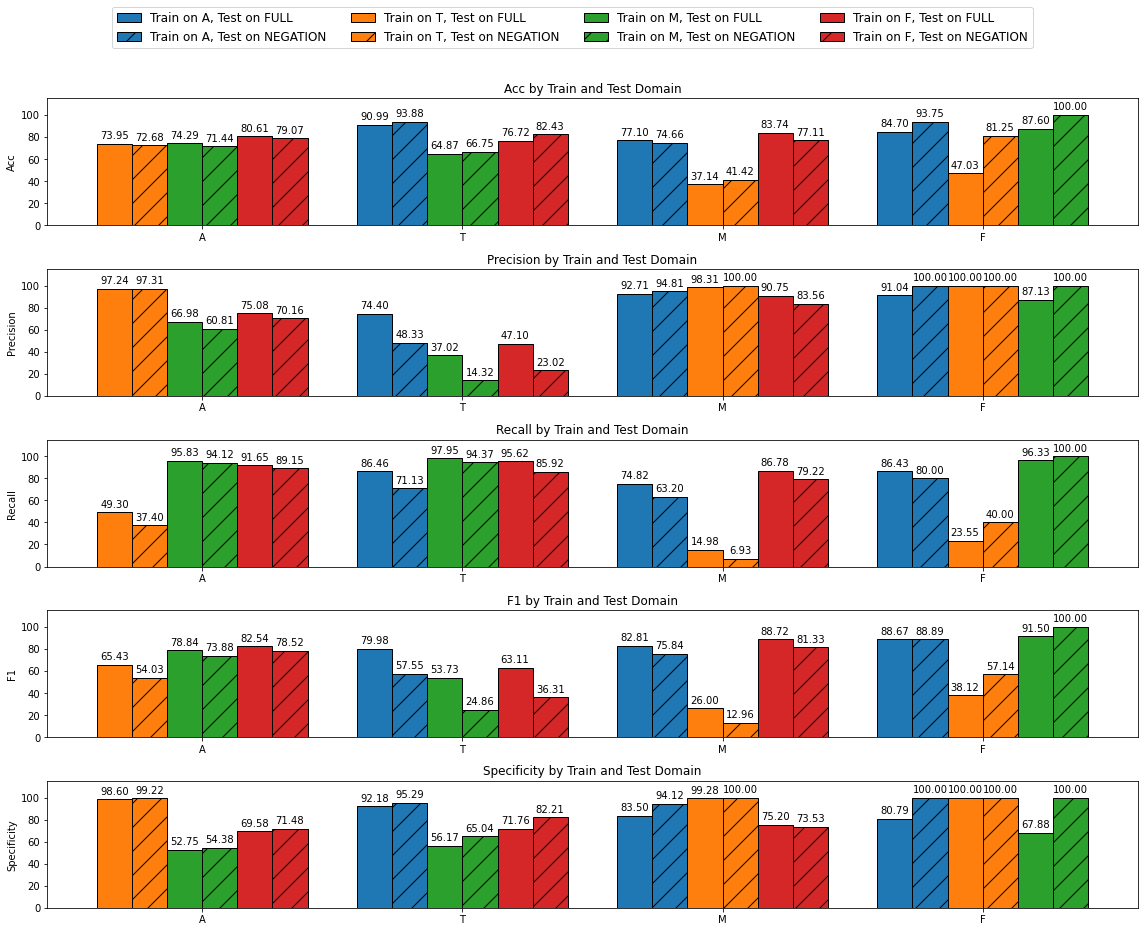

In [5]:
# draw bar charts
single_src_bar()

## Multi-source-domain Models
See the tables below. For each target, there are two rows: the upper one for the full test data, the lower one for the negation subset.

### Conclusions
1. Just like the models trained on a single source domain, models trained on multiple source domains (using ERM) exhibit the following properties when they are tested on the negation subset. This indicates that, although the correlations between $y$ and $has\_negation$ are averaged as the domains are mixed, this doesn't solve the problem that models tend to predict $y=0$ when they see negations.
    - Lower precision
    - Lower recall
    - Higher specificity
    
2. Models trained on multiple domains do not outperform the model trained on only the Amazon domain regarding average accuracy.

In [6]:
# draw tabulars
multi_src_tab()

                   algo: ERM   |   target: A                    
----------------------------------------------------------------
N       Acc     Precision   Recall  F1      Specificity     
----------------------------------------------------------------
8000    0.849   0.810       0.912   0.858   0.786           
5861    0.840   0.777       0.881   0.826   0.810           


                   algo: ERM   |   target: T                    
----------------------------------------------------------------
N       Acc     Precision   Recall  F1      Specificity     
----------------------------------------------------------------
8653    0.806   0.518       0.957   0.672   0.766           
2436    0.854   0.267       0.859   0.407   0.854           


                   algo: ERM   |   target: M                    
----------------------------------------------------------------
N       Acc     Precision   Recall  F1      Specificity     
-------------------------------------------------

## Visualization of Feature Importance

### Helper functions 
Have been put into precompute_vis.py

### For each (algorithm, target) pair, save pre-computed visualization
Have done in the terminal

### Hint
For each *algorithm* **A** and *target* **T**, which jointly specify a trained model, the visualization of samples *with negations* have been saved in **A_tgt_T_100_vis.pkl** (*100* for the *max_len* value).

The save format is a list of dicts, each dict corresponding to a sample whose `has_negation` is True and `num_token` $\leq$ 100. The keys are:
- **vis:** The visualization object.
- **index:** The index in the original DataFrame.
- **text:** The raw text of this sample.
- **label:** The label of this sample. This is a string being either 'positive' or 'negative'.
- **domain:** The domain of this sample.
- **pred:** The predicted label (also a string) of this sample by this very model.
- **pred_prob:** The probability assigned to the predicted label. Floating point number.

### $y=1, \hat{y}=0$, has negations

In [7]:
load_and_visualize('ERM', 'A', 100, 'A', label='positive', t_or_f='false')

+----------------------------------------------------------------------------------------+
|    Model: ERM_tgt_A; Domain: A; Max Len: 100; Start Index: 0; End Index: 20            |
+----------------------------------------------------------------------------------------+


[(14870,
  'This book gives a thorough analysis on how public policies were the catalysts for the socioeconomic destruction of low-income communities of color in New York City. Necessary reading for those who still do not  realize that activism and organizing are important vehicles through which  marginalized communities keep in check the forces that seek to further  fragment and disenfranchise them'),
 (15038,
  'Playstation and X-box have nothing over the toy of the future: a time-travel device which allows for visits to the past. There\'s only one problem with Theo\'s enjoyment of the latest model: it appears to be defective, and his interactions with peoples of the past increasingly holds dangers of changing the future. The debut titles in the newe "Jump-Man Rule" series by James Valentine, Don\'t Touch Anything provides quick action and unpredictable twists of plot, including romance, making it a most unusual, satisfying adventure story recommended for ages 8-12.'),
 (15050,
  "Ye

In [44]:
adversary = [
(15050, "Yes, it's the bible of cooking.  Its like a degree at the culinary institute.  However, its a hard book to cook from.  Most recipes refer to several parts of the book for details on how to prepare different parts of the recipe.  So you contstantly have to page back and forth in the book.  Its intimidating for the novice who just wants to cook, but if you really want to learn about cooking then its THE book to have"),
(15166, "You definetly should read this book! The Left claims that Bin Laden would opposite Saddam because of their beliefs, yet the Left is adamant that Osama bin Laden was funded by the United States. Go figure! We all knew there was a connection and Stephen Hayes demonstrates so with great care! There is a connection with al Qaeda and Iraq and the book explains it in detail"),
(15435, 'i am currently in psychology for the third time,(due to it had been too long between college classess) i think the book is informative and readable (if you have too!'),
(17692,
  "This video is awsome that every true Pantera fan likes this video. Only live gets better than this. Watch it Go!!!"),
(17812,
  'avoid PASSING THIS ONE UP. BUY THIS AMAZING DVD AND YOUR EARS WILL BE SATISFIED..'),
(18865,
  'Works great!!!  I have a flat roof that disallows me to add a phone line and the only way to use my satilite system is with a long phone cord accross my room.  This jack extension helped me eliminate the long ugly cor'),
]

visualize_adversary('ERM', 'A', adversary)

  0%|          | 0/1 [00:00<?, ?it/s]

### $y=1, \hat{y}=1$, no negations

In [45]:
all_data = pd.read_csv('postprocessed.csv')
all_data = all_data[(all_data['has_negation']==False) & (all_data['label']=='positive') &
                    (all_data['ERM_pred']=='positive') & (all_data['domain'] == 'A')]
# sort data by ascending prediction confidence
all_data = all_data.sort_values('ERM_pred_prob').reset_index()
indtxt = all_data[['index', 'text']].values.tolist()
indtxt = [tuple(e) for e in indtxt]
print(f'length: {len(indtxt)}')
indtxt[70:80]

length: 1432


[(17592,
  'As both a big fan of this movie and a film student, I feel that critics have been quick to judge this film as bad trash. This film has a sexy edge to it, that many other films in the "teen film" genre dare to exhibit. New Best Friend fullfills a fantasy for those girls who secretly desire to live dangerously and party every night, without it actually becoming a reality. The house is every girl\'s dream, and these girls are alluring and suavely tempting. The acting is far from terrible, and it was great to see Meredith Monroe  in a more sophisticated and darker role than her role as Andie in Dawson\'s Creek. Dominique Swain once again puts in an A+ effort for her role as the cheeky deviant Sydney. For anyone who loved films like Tart and Cruel intentions,this is the film for you.'),
 (21189,
  'ice bucket is smaller than i expected.  otherwise, a very good product'),
 (15779,
  'I am finding this book quite helpful to getting to know myself better and to have greater control

In [52]:
adversary = [
(15462, 'I knew the government was a little crooked...but when I read this....well...lets just say I dont trust the government anymore. Its a very great book, and fills you in on some information that you might not notice'),
(18928, 'This card has all of the memory space required for my personal use. Do not put it into the washing machine. I would recommemd it to others'),
(14949, 'For anybody, who wish to learn about the Orthodox Church, and Christianity in general for that matter, this book is "must-read". Do not pass this one up.'),
(21725, "The price went down from $6.95 to $3.95. You cannot beat the price. You cannot beat the price. It's very nice looking,you will be pleased with it.Approximately 13 and a half inch square.I was expecting a black cloth loop to hang it from,but the loop turned out to be the sewn in label.That's okay"),
(21599, "this is a wonderful hamper.  Do not believe anyone that says it is not wonderful. I do not know why anyone would ever say it is not wonderful. I live in a building where the laundry is in the basement, and this hamper is great, better than any shopping cart.  One complaint: it's handle is too short, I'm tall and have to slouch to one side when I roll it"),
(19727, 'Its a great graphics card, especially for the price. Do not believe anyone that says it does not work. I do not know why anyone would ever say it does not work. Under no circumstance will it not work. I got it to improve Roller Coaster Tycoon 3 and it did. But the controls arent as clear as they could be for the anti-aliasing settings and the anisotropic filtering'),
]

visualize_adversary('ERM', 'A', adversary, comparison=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
import nltk
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/v-runmao/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [57]:
positive = opinion_lexicon.positive()

In [60]:
positive[:20]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade',
 'accolades',
 'accommodative',
 'accomodative',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accurate',
 'accurately']

In [61]:
positive[-20:]

['work',
 'workable',
 'worked',
 'works',
 'world-famous',
 'worth',
 'worth-while',
 'worthiness',
 'worthwhile',
 'worthy',
 'wow',
 'wowed',
 'wowing',
 'wows',
 'yay',
 'youthful',
 'zeal',
 'zenith',
 'zest',
 'zippy']